In [ ]:
# pip install bing_image_downloader
# pip install tensorflow_datasets
# pip install keras

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from keras.preprocessing.image import ImageDataGenerator
from bing_image_downloader import downloader
from keras.models import load_model
from PIL import Image

Matplotlib created a temporary config/cache directory at /var/folders/th/4wk9mg4j3674pkjtsrtmfmzh0000gn/T/matplotlib-q8rqafup because the default path (/Users/shikharanand/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
query_string = ["norwegian male", "norwegian female", "indian male", "indian female"]
output_dir='dataset'

In [3]:
# downloader.download(query_string, 
#                     limit=10000,  
#                     output_dir='dataset', 
#                     adult_filter_off=True, 
#                     force_replace=False, 
#                     timeout=60)

In [4]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [5]:
base_dir = pathlib.Path.cwd() / output_dir
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(base_dir,
                                                               validation_split=VALIDATION_SPLIT,
                                                               subset='training',
                                                               seed=123,
                                                               image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                               batch_size=BATCH_SIZE)

Found 13485 files belonging to 4 classes.
Using 10788 files for training.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(base_dir,
                                                              validation_split=VALIDATION_SPLIT,
                                                              subset='validation',
                                                              seed=123,
                                                              image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                              batch_size=BATCH_SIZE)

Found 13485 files belonging to 4 classes.
Using 2697 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['indian female', 'indian male', 'norwegian female', 'norwegian male']


### Visualizing the dataset

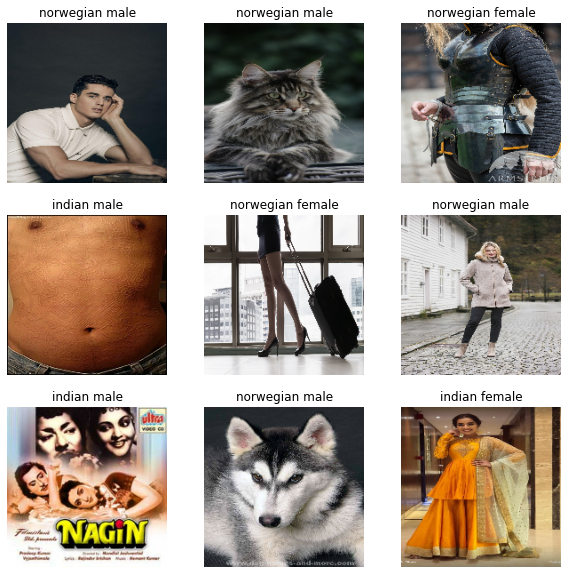

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

You can train a model using these datasets by passing them to model.fit.
If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch)
    print(labels_batch)
    print(len(image_batch))
    break

tf.Tensor(
[[[[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   ...
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]]

  [[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   ...
   [2.49958328e+02 2.49958328e+02 2.49958328e+02]
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]]

  [[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   ...
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]
   [2.50000000e+02 2.50000000e+02 2.50000000e+02]]

  ...

  [[3.52055588e+01 3.52055588e+01 3.52055588e+01]
   [3

### Standardize the data

In [11]:
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0012253724 0.9749003


### Configure the dataset for performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

In [14]:
num_classes = 5

model = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Conv2D(32, 3, activation='relu'),
                             layers.MaxPooling2D(),
                             layers.Flatten(),
                             layers.Dense(128, activation='relu'),
                             layers.Dense(num_classes)
                            ])

In [15]:
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
epochs = 1
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=epochs
                   )

169/169 [==============================] - 685s 4s/step - loss: 0.7708 - accuracy: 0.6820 - val_loss: 0.1474 - val_accuracy: 0.9614


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0

### Visualizing the Training Results

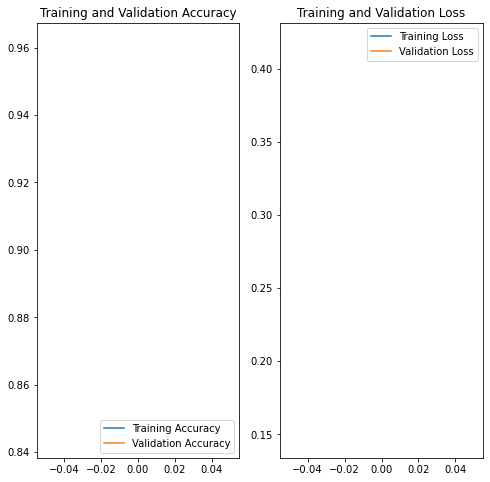

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Test model on unknown dataset

In [101]:
file_name = "test1.jpg"

In [102]:
# set the width and height of the result
width = 180
height = 180
img = Image.open(file_name)

# resize image and reshape
resized_img = img.resize((width,height), Image.ANTIALIAS)
test_image = np.reshape(resized_img, [1, 180, 180, 3])

In [103]:
# predict the test data
predictions = model.predict(test_image)
score = tf.nn.softmax(predictions[0])
class_name = class_names[np.argmax(score)]

In [104]:
print("The image most likely belongs to %s with a %.2f percent confidence." 
      %(class_names[np.argmax(score)], np.max(score)*100)
     )

The image most likely belongs to norwegian male with a 53.57 percent confidence.


### Developing and Testing model using VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

path = pathlib.Path.cwd() / "test1.jpg"

model = VGG16(weights='imagenet', include_top=False)

img_path = path
img = image.load_img(img_path, target_size=(180, 180))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)